# Code for generating Figure 1

In [50]:
%load_ext autoreload
%autoreload 2

# imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import torch

from functions.embedding_functions import GaussianMixture, NeuralEmbedding

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# saving-related utility function
pic_folder = 'results/'
format_list = ['.png', '.svg', '.pdf']

def save_plot(name):
    for end in format_list:
        plt.savefig(pic_folder+name+end, bbox_inches='tight', transparent=True)
    return

<center>
<img src="fig_images/fig-embed-examples.png" width="1000"/></center>

**Caption.** (a) The function $\boldsymbol{\phi}$ maps the latent space to the (higher-dimensional) ambient space. (b) Optimal one-dimensional embeddings when $p_{\text{data}}$ is a mixture of Gaussians centered at points along a line (left), circle (middle), or sinusoid (right).

## a. Cartoon schematic

Parameters.

In [24]:
FIGSIZE = (4, 4)
DPI = 150

# Camera/view
ELEV1 = 25
ELEV2 = 10
AZIM1 = -100
AZIM2 = -10

# ---- Flat sheet parameters ----
SHEET_LEN_X = 3.0     # total x-length of the rectangle
SHEET_LEN_Y = 2.0     # total y-length of the rectangle
SHEET_NX = 60         # x-resolution
SHEET_NY = 40         # y-resolution

# ---- Sphere + draped sheet parameters ----
R = 1.0               # sphere radius
SPHERE_U = 120        # sphere longitudinal resolution
SPHERE_V = 80         # sphere latitudinal resolution
SPHERE_ALPHA = 0.35   # sphere transparency (0=fully transparent, 1=opaque)

# Draped patch angular extents (top-right quadrant: u in [0, pi/2])
PATCH_U_MAX = 0.5 * np.pi      # how far around the +x,+y quadrant to wrap
PATCH_V_MAX = 0.55 * np.pi     # how far down from the north pole to wrap
PATCH_NU = 60                  # patch u-resolution
PATCH_NV = 60                  # patch v-resolution
PATCH_OFFSET = 0.02            # radial offset to avoid z-fighting with sphere (visual only)

Generate sheet representing latent space.

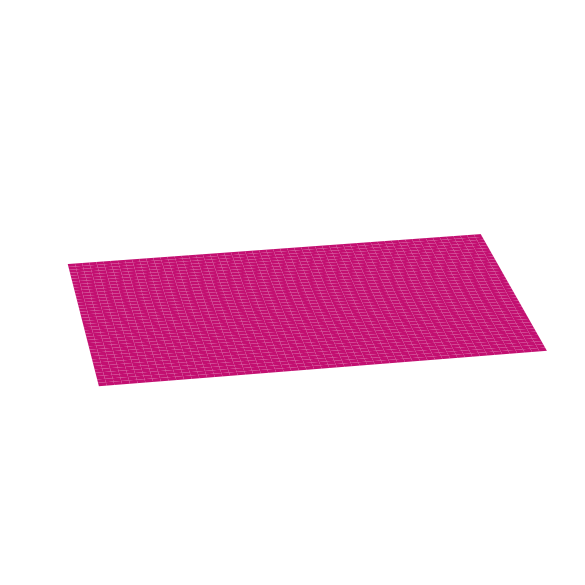

In [27]:
x = np.linspace(-SHEET_LEN_X/2, SHEET_LEN_X/2, SHEET_NX)
y = np.linspace(-SHEET_LEN_Y/2, SHEET_LEN_Y/2, SHEET_NY)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# -------

fig1 = plt.figure(figsize=FIGSIZE, dpi=DPI)
ax1 = fig1.add_subplot(111, projection="3d")

ax1.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=True, color='deeppink')

# Axes styling + camera
ax1.set_xlim(-SHEET_LEN_X/2 - 0.1, SHEET_LEN_X/2 + 0.1)
ax1.set_ylim(-SHEET_LEN_Y/2 - 0.1, SHEET_LEN_Y/2 + 0.1)
ax1.set_zlim(-0.4, 1.0)
ax1.view_init(elev=ELEV1, azim=AZIM1)
ax1.set_box_aspect((SHEET_LEN_X, SHEET_LEN_Y, 0.7))  

ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.axis('off')

plt.tight_layout()
save_plot('sheet_flat')
plt.show()

Generate sphere and draped sheet representing embedding into ambient space.

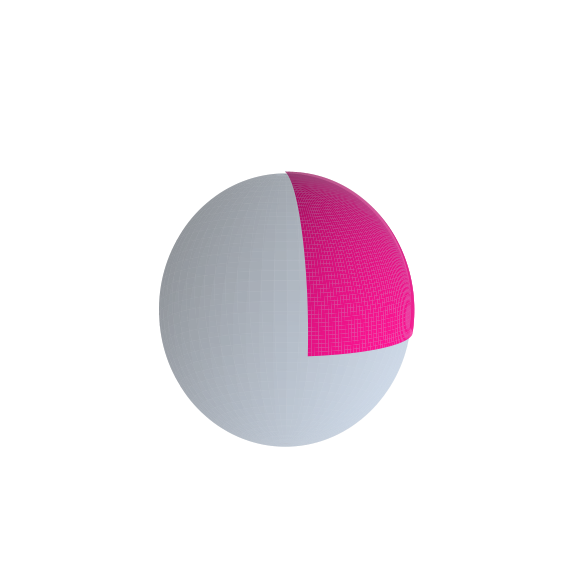

In [30]:
# Sphere surface (parametrized by u (longitude), v (colatitude))
u = np.linspace(0, 2*np.pi, SPHERE_U)
v = np.linspace(0, np.pi, SPHERE_V)
U, V = np.meshgrid(u, v)
Xs = R * np.cos(U) * np.sin(V)
Ys = R * np.sin(U) * np.sin(V)
Zs = R * np.cos(V)

# Draped "sheet" patch: a spherical patch over the top-right quadrant
u_patch = np.linspace(0.0, PATCH_U_MAX, PATCH_NU)    # +x, +y
v_patch = np.linspace(0.0, PATCH_V_MAX, PATCH_NV)    # from north pole downward
Up, Vp = np.meshgrid(u_patch, v_patch)

# Slight radial offset prevents z-fighting with the sphere
R_sheet = R + PATCH_OFFSET
Xd = R_sheet * np.cos(Up) * np.sin(Vp)
Yd = R_sheet * np.sin(Up) * np.sin(Vp)
Zd = R_sheet * np.cos(Vp)

# -------

fig2 = plt.figure(figsize=FIGSIZE, dpi=DPI)
ax2 = fig2.add_subplot(111, projection="3d")


# Plot the semi-transparent sphere
ax2.plot_surface(
    Xs, Ys, Zs,
    rstride=2, cstride=2, linewidth=0, antialiased=True,
    alpha=SPHERE_ALPHA, shade=True, color='lightsteelblue'
)

ax2.plot_surface(
    Xd, Yd, Zd,
    rstride=1, cstride=1, linewidth=0.2, antialiased=True, color='deeppink'
)

# Axes styling & camera
ax2.set_xlim(-1.2*R, 1.4*R)
ax2.set_ylim(-1.2*R, 1.4*R)
ax2.set_zlim(-1.0*R, 1.4*R)
ax2.view_init(elev=ELEV2, azim=AZIM2)
ax2.set_box_aspect((1.0, 1.0, 1.0))

ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

ax2.axis('off')
plt.tight_layout()
save_plot('draped_sheet')
plt.show()

## b. Example one-dimensional embeddings

### Line

In [59]:
def get_points_line(num_pts, sigma=0.1):
    weights = np.ones(num_pts)/num_pts
    sigmas = np.ones(num_pts)*sigma

    z = np.linspace(0, 1, num_pts, dtype=float)

    mus = []; mu_plot = []
    for i in range(num_pts):
        mus.append(torch.tensor([z[i],z[i]])  )
        mu_plot.append( [z[i], z[i]] )
    mu_plot = np.array(mu_plot)
    
    return weights, mus, sigmas, mu_plot

Set up.

In [62]:
# Get ambient space log p
num_pts = 100
weights, mus, sigmas, mu_plot = get_points_line(num_pts, sigma=0.1)
gm = GaussianMixture(weights=weights, mus=mus, sigmas=sigmas)
log_p_data_fn = gm.log_prob

# Set up embedding
emb1d = NeuralEmbedding(
    d=1, D=2, hidden=128, depth=3, 
    q_mode='uniform',
    bounds=[[-1.0, 1.0]],  
    device='cpu', seed=0
)

Train.

In [65]:
emb1d.train(log_p_data_fn, steps=4000, batch=1024, lr=2e-3, cont_lambda=1e-2, print_every=300)

[    1] J=-33.0621  kin=0.3744  logp=-33.4365  cont=2.1146
[  300] J=0.5791  kin=-0.2111  logp=0.7902  cont=0.6557
[  600] J=0.6253  kin=-0.2964  logp=0.9217  cont=0.5528
[  900] J=0.6242  kin=-0.2633  logp=0.8875  cont=0.5906
[ 1200] J=0.6341  kin=-0.2713  logp=0.9054  cont=0.5812
[ 1500] J=0.6197  kin=-0.3048  logp=0.9246  cont=0.5435
[ 1800] J=0.6321  kin=-0.2704  logp=0.9025  cont=0.5823
[ 2100] J=0.6151  kin=-0.3579  logp=0.9729  cont=0.4888
[ 2400] J=0.6326  kin=-0.2896  logp=0.9222  cont=0.5604
[ 2700] J=0.6344  kin=-0.2336  logp=0.8680  cont=0.6268
[ 3000] J=0.6240  kin=-0.2982  logp=0.9222  cont=0.5508
[ 3300] J=0.6364  kin=-0.2648  logp=0.9012  cont=0.5889
[ 3600] J=0.6267  kin=-0.3148  logp=0.9415  cont=0.5328
[ 3900] J=0.6391  kin=-0.2585  logp=0.8976  cont=0.5963


Sequential(
  (0): Linear(in_features=1, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): Linear(in_features=128, out_features=2, bias=True)
)

Plot.

In [73]:
n = 100
zmin, zmax = -1, 1
with torch.no_grad():
    z = torch.linspace(zmin, zmax, n, dtype=emb1d.dtype, device=emb1d.device).unsqueeze(1)  # [n,1]
    X = emb1d.forward(z).cpu().numpy()   

In [77]:
emb = emb1d

density_grid = 200
density_levels = 20

xx, yy = X[:,0], X[:,1]

pad = 1
eps = 0.1
xlim = (-eps, 1 + eps) 
ylim = (-eps, 1 + eps)

gx = np.linspace(*xlim, density_grid)
gy = np.linspace(*ylim, density_grid)
GX, GY = np.meshgrid(gx, gy, indexing='xy')
grid = torch.tensor(np.stack([GX, GY], axis=-1).reshape(-1,2), dtype=emb.dtype, device=emb.device)

with torch.no_grad():
    L = log_p_data_fn(grid).reshape(density_grid, density_grid).cpu().numpy()

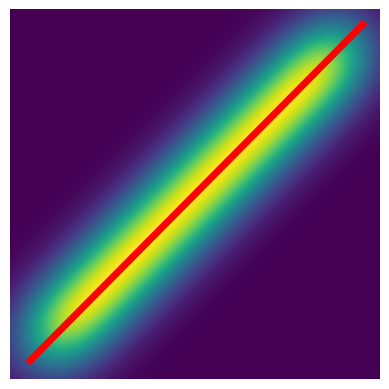

In [83]:
fig, ax = plt.subplots()

plt.plot(X[:,0], X[:,1], linewidth=5,zorder=3, color='red')
ax.imshow(np.exp(L).T, origin='lower', extent=[0 - eps, 1 + eps, 0 - eps, 1 + eps])
ax.axis('off')
save_plot('line')
plt.show()

### Circle

In [85]:
def get_points_circle(num_pts, sigma=0.1):
    weights = np.ones(num_pts)/num_pts
    sigmas = np.ones(num_pts)*sigma

    z = np.linspace(0, 2*np.pi, num_pts, dtype=float)

    mus = []; mu_plot = []
    for i in range(num_pts):
        mus.append(torch.tensor([np.cos(z[i]),np.sin(z[i])])  )
        mu_plot.append( [np.cos(z[i]),np.sin(z[i])] )
    mu_plot = np.array(mu_plot)

    return weights, mus, sigmas, mu_plot

Set up.

In [ ]:
# Get ambient space log p
num_pts = 100
weights, mus, sigmas, mu_plot = get_points_circle(num_pts, sigma=0.1)
gm = GaussianMixture(weights=weights, mus=mus, sigmas=sigmas)
log_p_data_fn = gm.log_prob

# Setup embedding
emb_cir = NeuralEmbedding(
    d=1, D=2, hidden=128, depth=3, 
    q_mode='uniform',
    bounds=[[-1.0, 1.0]],   
    device='cpu', seed=0
)

Train.

In [ ]:
emb_cir.train(log_p_data_fn, steps=4000, batch=1024, lr=2e-3, cont_lambda=1e-2, print_every=300)

Plot.

In [ ]:
n = 1000
zmin, zmax = -1, 1
with torch.no_grad():
    z = torch.linspace(zmin, zmax, n, dtype=emb_cir.dtype, device=emb_cir.device).unsqueeze(1)  # [n,1]
    X = emb_cir.forward(z).cpu().numpy()   

In [ ]:
emb = emb_cir

density_grid = 200
density_levels = 20

xx, yy = X[:,0], X[:,1]

pad = 1
eps = 0.1

x_min, x_max = -1, 1
y_min, y_max = -1, 1
xlim = (-eps + x_min, x_max + eps)
ylim = (-eps + y_min, y_max + eps)

gx = np.linspace(*xlim, density_grid)
gy = np.linspace(*ylim, density_grid)
GX, GY = np.meshgrid(gx, gy, indexing='xy')
grid = torch.tensor(np.stack([GX, GY], axis=-1).reshape(-1,2), dtype=emb.dtype, device=emb.device)

with torch.no_grad():
    L = log_p_data_fn(grid).reshape(density_grid, density_grid).cpu().numpy()

In [ ]:
fig, ax = plt.subplots()

plt.plot(X[:,0], X[:,1], linewidth=5,zorder=3, color='red')
ax.imshow(np.exp(L).T, origin='lower', extent=[x_min - eps, x_max + eps, y_min - eps, y_max + eps])
ax.axis('off')
save_plot('circle')
plt.show()

### Sinusoid

In [ ]:
def get_points_sine(num_pts, sigma=0.1):
    weights = np.ones(num_pts)/num_pts
    sigmas = np.ones(num_pts)*sigma

    z = np.linspace(0, 2*np.pi, num_pts, dtype=float)

    mus = []; mu_plot = []
    for i in range(num_pts):
        mus.append(torch.tensor([z[i],np.sin(z[i])])  )
        mu_plot.append([z[i],np.sin(z[i])])
    mu_plot = np.array(mu_plot)
    
    return weights, mus, sigmas, mu_plot

Set up.

In [ ]:
# Get ambient space log p
num_pts = 100
weights, mus, sigmas, mu_plot = get_points_sine(num_pts, sigma=0.1)
gm = GaussianMixture(weights=weights, mus=mus, sigmas=sigmas)
log_p_data_sine = gm.log_prob

# Set up embedding
emb_sin = NeuralEmbedding(
    d=1, D=2, hidden=128, depth=3, 
    q_mode='uniform',
    bounds=[[-1.0, 1.0]], 
    device='cpu', seed=0
)

Train.

In [ ]:
emb_sin.train(log_p_data_sine, steps=4000, batch=1024, lr=1e-3, cont_lambda=1e-2, print_every=300)

Plot.

In [ ]:
n = 1000
zmin, zmax = -1, 1
with torch.no_grad():
    z = torch.linspace(zmin, zmax, n, dtype=emb_sin.dtype, device=emb_sin.device).unsqueeze(1)  # [n,1]
    X = emb_sin.forward(z).cpu().numpy()   

In [ ]:
emb = emb_sin

density_grid = 200
density_levels = 20

xx, yy = X[:,0], X[:,1]
pad = 1
eps = 0.1

x_min, x_max = 0, 2*np.pi
y_min, y_max = -1, 1
xlim = (-eps + x_min, x_max + eps) 
ylim = (-eps + y_min, y_max + eps)

gx = np.linspace(*xlim, density_grid)
gy = np.linspace(*ylim, density_grid)
GX, GY = np.meshgrid(gx, gy, indexing='xy')
grid = torch.tensor(np.stack([GX, GY], axis=-1).reshape(-1,2), dtype=emb.dtype, device=emb.device)

with torch.no_grad():
    L = log_p_data_sine(grid).reshape(density_grid, density_grid).cpu().numpy()

In [ ]:
fig, ax = plt.subplots()

plt.plot(X[:,0], X[:,1], linewidth=5,zorder=3, color='red')
ax.imshow(np.exp(L), origin='lower', extent=[x_min - eps, x_max + eps, y_min - eps, y_max + eps])
ax.set_aspect(np.pi)
ax.axis('off')

save_plot('sine')
plt.show()